# Food Security

There are over 200 definitions of food security however the most internationally accepted definition is; food security exists when all people at all-time have both physical and economic access to sufficient, safe and nutritious food that meets their dietary need and food preferences for an active and healthy life.Food security is a multidimensional concept that involves various factors that cut across social, political, environmental and economic issues. The four pillars of food security are:
1. Availability.
2. Access.
3. Utilization.
4. Stability.

## Explolatory Data Analysis

In [1]:
# Import relevant libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import sklearn as sk
from math import sqrt
import fiona
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# import data
file_name = "data/Counties_food_security.shp"
fs_df = gpd.read_file(file_name)


In [3]:
#Change data type for column 'Code' and make it the index column
fs_df.set_index(fs_df.Code.astype(int),inplace=True)
fs_df.sort_index(inplace=True)

In [4]:
# Print columns names
pd.set_option('display.max_colwidth', 18)
fs_df.columns

Index(['COUNTY', 'Code', 'Severe_stu', 'Severe_was', 'Severe_und',
       'Food_pover', 'Poor_Feedi', 'Borderline', 'Unacceptab', 'Maize_Prod',
       'Beans_Prod', 'TLU', 'Land_Area_', 'Arable_Lan', 'Arable_L_1',
       'Rural_Popu', 'Urban_Popu', 'Total_Popu', 'Population', 'Male_Liter',
       'Female_Lit', 'Overall_Li', 'poverty_ra', 'GCP_USD', 'Mean_dista',
       'Conflict_c', 'Food_Sourc', 'Food_Sou_1', 'Food_Sou_2', 'Food_sou_3',
       'Access_imp', 'Access_to_', 'Access_to1', 'Average_Ra', 'Evapotrans',
       'ObjectID', 'geometry'],
      dtype='object')

In [5]:
# Rename columns
new_columns_name = {'Severe_stu':'Severe stunting in children (%)',
          'Severe_was':'Severe wasting in children (%)',
       'Severe_und':'Severe underweight (%)', 
        'Food_pover':'Food poverty rate (%)', 
        'Poor_Feedi':'Poor_Feeding_Score',
        'Borderline':'Borderline_feeding_score', 
        'Unacceptab':'Unacceptable_Feeding_Score',
       'Maize_Prod':'Maize_Production(Ton)', 
        'Beans_Prod':'Beans_Production(Ton)',
        'TLU':'Tropical Livestock Unit', 
        'Land_Area_':'Land Area (Km2)',
        'Arable_Lan':'Arable Land (Km2)',
       'Arable_L_1':'Arable Land (%)',
        'Rural_Popu':'Rural_Population', 
        'Urban_Popu':'Urban_Population',
        'Total_Popu':'Total Population', 
        'Population':'Population_Density/sqKm',
       'Male_Liter':'Male Literacy',
        'Female_Lit':'Female Literacy',
        'Overall_Li':'Overall Literacy',
        'poverty_ra':'poverty_rate_percentage',
        'GCP_USD':'GCP_USD',
       'Mean_dista':'Mean_distance_to_roads',
        'Conflict_c':'Conflict_cases_per_year',
        'Food_Sourc':'Food_Source_Purchases', 
        'Food_Sou_1':'Food_Source_Stock', 
        'Food_Sou_2':'Food_Source_Own_production',
       'Food_sou_3':'Food_source_Gifts',
        'Access_imp':'Access_improved Sanitation services',
        'Access_to_':'Access to Water',
        'Access_to1':'Access to_Unimproved Sanitation Services',
        'Average_Ra':'Average Rainfall',
       'Evapotrans':'Evapotransipiration',
          }


In [6]:
fs_df.rename(columns=new_columns_name, inplace=True)

In [7]:
# Print new columns names
fs_df.columns

Index(['COUNTY', 'Code', 'Severe stunting in children (%)',
       'Severe wasting in children (%)', 'Severe underweight (%)',
       'Food poverty rate (%)', 'Poor_Feeding_Score',
       'Borderline_feeding_score', 'Unacceptable_Feeding_Score',
       'Maize_Production(Ton)', 'Beans_Production(Ton)',
       'Tropical Livestock Unit', 'Land Area (Km2)', 'Arable Land (Km2)',
       'Arable Land (%)', 'Rural_Population', 'Urban_Population',
       'Total Population', 'Population_Density/sqKm', 'Male Literacy',
       'Female Literacy', 'Overall Literacy', 'poverty_rate_percentage',
       'GCP_USD', 'Mean_distance_to_roads', 'Conflict_cases_per_year',
       'Food_Source_Purchases', 'Food_Source_Stock',
       'Food_Source_Own_production', 'Food_source_Gifts',
       'Access_improved Sanitation services', 'Access to Water',
       'Access to_Unimproved Sanitation Services', 'Average Rainfall',
       'Evapotransipiration', 'ObjectID', 'geometry'],
      dtype='object')

In [8]:
# Print df shape
fs_df.shape

(47, 37)

In [9]:
# Print the first five columns of the data frame
fs_df.head()

,COUNTY,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),...,Food_Source_Stock,Food_Source_Own_production,Food_source_Gifts,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID,geometry
Code,,,,,,,,,,,,,,,,,,,,,
1,Mombasa,1.0,11.9,2.5,2.6,2.2,1.0,7.0,8.0,309.0,...,7.5,0.4,3.0,86.3,44.2,27.2,1184.868526,0.651168,28,MULTIPOLYGON (...
2,Kwale,2.0,13.9,2.5,0.4,5.9,2.0,18.0,20.0,62103.0,...,4.8,20.7,3.6,33.7,82.7,44.7,876.933624,0.536560,19,MULTIPOLYGON (...
3,Kilifi,3.0,10.8,1.4,1.3,7.0,1.0,12.0,13.0,54675.0,...,7.5,15.5,7.0,70.0,65.9,1.6,822.434090,0.480857,14,MULTIPOLYGON (...
4,Tana River,4.0,11.4,6.0,1.6,17.9,5.0,15.0,20.0,3536.0,...,4.7,9.0,5.1,60.6,74.9,38.3,563.185214,0.291208,40,POLYGON ((38.7...
5,Lamu,5.0,10.5,4.3,1.5,3.2,0.0,8.0,8.0,29025.0,...,6.0,13.2,4.6,70.0,67.8,34.4,812.305999,0.468851,21,MULTIPOLYGON (...


In [10]:
# Print the last five columns of the data frame
fs_df.tail()

,COUNTY,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),...,Food_Source_Stock,Food_Source_Own_production,Food_source_Gifts,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID,geometry
Code,,,,,,,,,,,,,,,,,,,,,
43,Homa Bay,43.0,13.4,2.6,3.0,5.9,2.0,3.0,16.0,119.0,...,9.4,17.6,17.0,45.1,59.8,54.9,1325.608461,0.637592,7,POLYGON ((34.4...
44,Migori,44.0,11.5,1.1,2.8,3.6,1.0,13.0,14.0,128126.0,...,8.0,32.4,4.3,37.9,69.3,16.9,1333.619813,0.699076,27,POLYGON ((34.6...
45,Kisii,45.0,13.6,0.7,4.1,7.5,1.0,10.0,11.0,154183.0,...,9.0,25.5,4.5,41.3,68.4,16.5,1738.029508,0.997031,16,POLYGON ((34.8...
46,Nyamira,46.0,5.5,0.9,2.7,7.6,0.0,18.0,18.0,91041.0,...,18.3,26.8,8.4,40.4,87.3,15.6,1683.384913,1.001155,34,POLYGON ((35.0...
47,Nairobi,47.0,11.8,1.6,1.8,0.6,2.0,8.0,10.0,457.0,...,9.2,1.6,2.6,91.9,48.4,28.6,833.709756,0.502875,30,POLYGON ((37.1...


In [11]:
fs_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 47 entries, 1 to 47
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   COUNTY                                    47 non-null     object  
 1   Code                                      47 non-null     float64 
 2   Severe stunting in children (%)           47 non-null     float64 
 3   Severe wasting in children (%)            47 non-null     float64 
 4   Severe underweight (%)                    47 non-null     float64 
 5   Food poverty rate (%)                     47 non-null     float64 
 6   Poor_Feeding_Score                        47 non-null     float64 
 7   Borderline_feeding_score                  47 non-null     float64 
 8   Unacceptable_Feeding_Score                47 non-null     float64 
 9   Maize_Production(Ton)                     47 non-null     float64 
 10  Beans_Production(Ton

In [12]:
fs_df.describe()

,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),Beans_Production(Ton),...,Food_Source_Purchases,Food_Source_Stock,Food_Source_Own_production,Food_source_Gifts,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,24.000000,11.308511,3.070213,3.117021,10.644681,2.212766,10.787234,13.170213,84324.531915,16297.361702,...,64.134043,9.304255,20.653191,5.859574,59.119149,65.329787,40.874468,1026.693364,0.597710,24.000000
std,13.711309,3.642015,2.909872,3.983680,11.091160,2.873690,5.225091,7.111898,109516.388380,18278.600955,...,11.254956,6.632888,9.536015,3.082677,24.412039,17.932578,24.389105,417.020621,0.261364,13.711309
min,1.000000,3.000000,0.000000,0.000000,0.200000,0.000000,2.000000,3.000000,0.000000,0.000000,...,38.000000,2.200000,0.400000,1.900000,6.200000,27.800000,1.300000,314.380546,0.133693,1.000000
25%,12.500000,8.400000,1.050000,0.750000,3.850000,1.000000,7.500000,9.000000,19746.500000,251.000000,...,57.150000,5.950000,13.300000,4.000000,39.850000,53.150000,17.550000,732.168188,0.422925,12.500000
50%,24.000000,11.100000,2.100000,1.600000,7.000000,2.000000,10.000000,12.000000,54675.000000,10827.000000,...,61.900000,8.200000,21.500000,5.100000,60.600000,67.200000,39.300000,1011.279505,0.631576,24.000000
75%,35.500000,13.600000,4.500000,2.900000,11.750000,3.000000,13.000000,15.500000,91821.000000,26643.500000,...,70.450000,10.400000,28.550000,6.800000,82.500000,79.850000,60.150000,1339.134350,0.822180,35.500000
max,47.000000,18.500000,11.900000,16.600000,52.700000,19.000000,24.000000,43.000000,548197.000000,83945.000000,...,88.900000,47.200000,38.100000,17.000000,98.800000,97.100000,93.700000,1857.249231,1.024794,47.000000


# Food Security Indicator Categorization

<center><h2><u>Proxy Food Security Indicators</u></h2></center>
 

| Dimensions   | Food Security Indicators   |
| ------  | ------ |
| Availability| Bean Production(Ton)|
| | Bean Production(Ton)|
| |Maize production(Ton)|
| | Tropical Livestock Unit|
| | Land Area (Km2)|
| | Arable Land (Km2)|
| |Arable Land (%)|
| | Average Rainfall|
| | Evapotransipiration|
|Accessibility|poverty_rate_percentage|
| | Conflict_cases_per_year|
| | Mean_distance_to_roads|
| Utilization| Severe stunting in children(%)|
| | Severe wasting in children (%)|
| | Severe underweight (%)|
| | Male Literacy|
| | Female Literacy|
| | Overall Literacy|
| | Access_improved Sanitation services|
| | Access to_Unimproved Sanitation Services|
| | Food poverty rate (%)|
| |Poor_Feeding_Score|
| | Borderline_feeding_score|
| | Unacceptable_Feeding_Score|
|Stability|Food source purchase|
| | Food_Source_Purchases|
| | Food_Source_Stock|
| | Food_Source_Own_production|
| | GCP_USD|
| | Rural_Population|
| | Urban_Population|
| | Total Population|
| | Population_Density/sqKm|


In [13]:
#Food Security dimension variables
availability=['Beans_Production(Ton)','Maize_Production(Ton)','Tropical Livestock Unit','Land Area (Km2)', 'Arable Land (Km2)',
       'Arable Land (%)','Average Rainfall','Evapotransipiration']
accessibility = ['poverty_rate_percentage','Conflict_cases_per_year','Mean_distance_to_roads']
utilization = ['Severe stunting in children (%)','Severe wasting in children (%)', 'Severe underweight (%)','Male Literacy','Female Literacy', 'Overall Literacy', 'Access_improved Sanitation services', 'Access to Water',
       'Access to_Unimproved Sanitation Services','Food poverty rate (%)', 'Poor_Feeding_Score','Borderline_feeding_score', 'Unacceptable_Feeding_Score']
stability = ['Rural_Population', 'Urban_Population','Total Population', 'Population_Density/sqKm','Food_Source_Purchases', 'Food_Source_Stock','Food_Source_Own_production']

In [14]:
#Food Security dimension dataframes
availability_df = fs_df[availability]
accessibility_df = fs_df[accessibility]
utilization_df = fs_df[utilization]
stability_df=fs_df[stability]

# Availability

In [15]:
availability_df.head()

,Beans_Production(Ton),Maize_Production(Ton),Tropical Livestock Unit,Land Area (Km2),Arable Land (Km2),Arable Land (%),Average Rainfall,Evapotransipiration
Code,,,,,,,,
1,0.0,309.0,14708.740,226.0,167.858892,74.273846,1184.868526,0.651168
2,71.0,62103.0,412617.000,8243.0,3411.076602,41.381495,876.933624,0.536560
3,21.0,54675.0,1005388.760,12500.0,5389.473138,43.115785,822.434090,0.480857
4,0.0,3536.0,824546.980,37822.0,705.408480,1.865075,563.185214,0.291208
5,0.0,29025.0,149903.096,6171.0,468.390802,7.590193,812.305999,0.468851


In [16]:
availability_df.describe()

,Beans_Production(Ton),Maize_Production(Ton),Tropical Livestock Unit,Land Area (Km2),Arable Land (Km2),Arable Land (%),Average Rainfall,Evapotransipiration
count,47.000000,47.000000,4.700000e+01,47.000000,47.000000,47.000000,47.000000,47.000000
mean,16297.361702,84324.531915,6.376390e+05,12572.361702,2344.831948,52.236843,1026.693364,0.597710
std,18278.600955,109516.388380,7.430866e+05,17803.683120,2279.039535,33.613125,417.020621,0.261364
min,0.000000,0.000000,1.470874e+04,226.000000,90.628640,0.253407,314.380546,0.133693
25%,251.000000,19746.500000,2.814649e+05,2673.000000,1194.978632,17.992344,732.168188,0.422925
50%,10827.000000,54675.000000,3.997556e+05,3510.000000,2071.581788,61.390139,1011.279505,0.631576
75%,26643.500000,91821.000000,6.436516e+05,14825.500000,2659.057506,79.000555,1339.134350,0.822180
max,83945.000000,548197.000000,4.498880e+06,75925.000000,14684.988342,99.855863,1857.249231,1.024794


### Dimensionality Reduction using PCA

In [17]:
# Separating out the features
x = availability_df.loc[:, availability].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA Analysis
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalComponents

fs_df["availability"]=principalComponents
fs_df.head()

,COUNTY,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),...,Food_Source_Own_production,Food_source_Gifts,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID,geometry,availability
Code,,,,,,,,,,,,,,,,,,,,,
1,Mombasa,1.0,11.9,2.5,2.6,2.2,1.0,7.0,8.0,309.0,...,0.4,3.0,86.3,44.2,27.2,1184.868526,0.651168,28,MULTIPOLYGON (...,-0.647122
2,Kwale,2.0,13.9,2.5,0.4,5.9,2.0,18.0,20.0,62103.0,...,20.7,3.6,33.7,82.7,44.7,876.933624,0.536560,19,MULTIPOLYGON (...,0.482050
3,Kilifi,3.0,10.8,1.4,1.3,7.0,1.0,12.0,13.0,54675.0,...,15.5,7.0,70.0,65.9,1.6,822.434090,0.480857,14,MULTIPOLYGON (...,0.957589
4,Tana River,4.0,11.4,6.0,1.6,17.9,5.0,15.0,20.0,3536.0,...,9.0,5.1,60.6,74.9,38.3,563.185214,0.291208,40,POLYGON ((38.7...,2.819730
5,Lamu,5.0,10.5,4.3,1.5,3.2,0.0,8.0,8.0,29025.0,...,13.2,4.6,70.0,67.8,34.4,812.305999,0.468851,21,MULTIPOLYGON (...,1.074569


In [18]:
availability = fs_df.availability.map(lambda p:p*-1)
fs_df['availability']=availability
fs_df.head()

,COUNTY,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),...,Food_Source_Own_production,Food_source_Gifts,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID,geometry,availability
Code,,,,,,,,,,,,,,,,,,,,,
1,Mombasa,1.0,11.9,2.5,2.6,2.2,1.0,7.0,8.0,309.0,...,0.4,3.0,86.3,44.2,27.2,1184.868526,0.651168,28,MULTIPOLYGON (...,0.647122
2,Kwale,2.0,13.9,2.5,0.4,5.9,2.0,18.0,20.0,62103.0,...,20.7,3.6,33.7,82.7,44.7,876.933624,0.536560,19,MULTIPOLYGON (...,-0.482050
3,Kilifi,3.0,10.8,1.4,1.3,7.0,1.0,12.0,13.0,54675.0,...,15.5,7.0,70.0,65.9,1.6,822.434090,0.480857,14,MULTIPOLYGON (...,-0.957589
4,Tana River,4.0,11.4,6.0,1.6,17.9,5.0,15.0,20.0,3536.0,...,9.0,5.1,60.6,74.9,38.3,563.185214,0.291208,40,POLYGON ((38.7...,-2.819730
5,Lamu,5.0,10.5,4.3,1.5,3.2,0.0,8.0,8.0,29025.0,...,13.2,4.6,70.0,67.8,34.4,812.305999,0.468851,21,MULTIPOLYGON (...,-1.074569


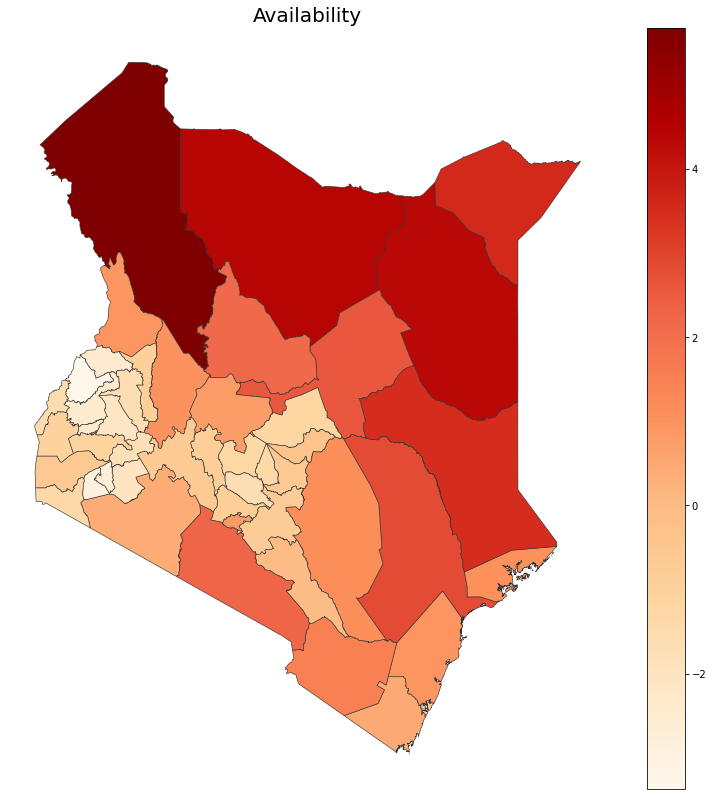

In [19]:
fig, ax = plt.subplots(1, figsize=(14,14))
fs_df.plot(column=fs_df.availability.map(lambda p:p*-1), cmap='OrRd', linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax);
ax.axis('off')
ax.set_title("Availability",fontsize=20);

# Accesibility

In [20]:
accessibility_df.head()

,poverty_rate_percentage,Conflict_cases_per_year,Mean_distance_to_roads
Code,,,
1,37.6,16.217391,3.533860
2,72.9,3.217391,13.335895
3,66.9,3.913043,19.340122
4,75.4,4.826087,66.472994
5,30.6,6.347826,33.987982


### PCA Analysis

In [21]:
x = accessibility_df.loc[:, accessibility].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA Analysis
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalComponents

fs_df["accessibility"]=principalComponents

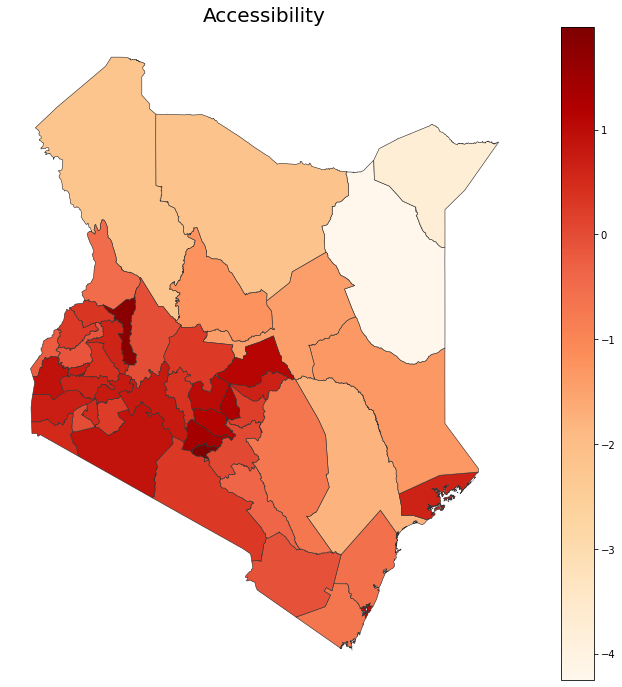

In [22]:
fig, ax = plt.subplots(1, figsize=(14,12))
fs_df.plot(column=fs_df.accessibility.map(lambda p:p*-1), cmap='OrRd', linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax);
ax.axis('off')
ax.set_title("Accessibility",fontsize=20);

# Utilization

In [23]:
utilization_df.head()

,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Male Literacy,Female Literacy,Overall Literacy,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score
Code,,,,,,,,,,,,,
1,11.9,2.5,2.6,96.1,93.2,94.7,86.3,44.2,27.2,2.2,1.0,7.0,8.0
2,13.9,2.5,0.4,79.9,55.7,67.7,33.7,82.7,44.7,5.9,2.0,18.0,20.0
3,10.8,1.4,1.3,90.7,70.4,80.1,70.0,65.9,1.6,7.0,1.0,12.0,13.0
4,11.4,6.0,1.6,78.8,58.2,68.6,60.6,74.9,38.3,17.9,5.0,15.0,20.0
5,10.5,4.3,1.5,87.3,77.3,82.2,70.0,67.8,34.4,3.2,0.0,8.0,8.0


### PCA Analysis

In [24]:
x = utilization_df.loc[:, utilization].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA Analysis
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalComponents

fs_df["utilization"]=principalComponents

In [25]:
fs_df.head()

,COUNTY,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),...,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID,geometry,availability,accessibility,utilization
Code,,,,,,,,,,,,,,,,,,,,,
1,Mombasa,1.0,11.9,2.5,2.6,2.2,1.0,7.0,8.0,309.0,...,86.3,44.2,27.2,1184.868526,0.651168,28,MULTIPOLYGON (...,0.647122,-1.003830,-2.196242
2,Kwale,2.0,13.9,2.5,0.4,5.9,2.0,18.0,20.0,62103.0,...,33.7,82.7,44.7,876.933624,0.536560,19,MULTIPOLYGON (...,-0.482050,0.690094,1.050718
3,Kilifi,3.0,10.8,1.4,1.3,7.0,1.0,12.0,13.0,54675.0,...,70.0,65.9,1.6,822.434090,0.480857,14,MULTIPOLYGON (...,-0.957589,0.559464,-0.977813
4,Tana River,4.0,11.4,6.0,1.6,17.9,5.0,15.0,20.0,3536.0,...,60.6,74.9,38.3,563.185214,0.291208,40,POLYGON ((38.7...,-2.819730,1.782179,1.699942
5,Lamu,5.0,10.5,4.3,1.5,3.2,0.0,8.0,8.0,29025.0,...,70.0,67.8,34.4,812.305999,0.468851,21,MULTIPOLYGON (...,-1.074569,-0.626839,-1.176142


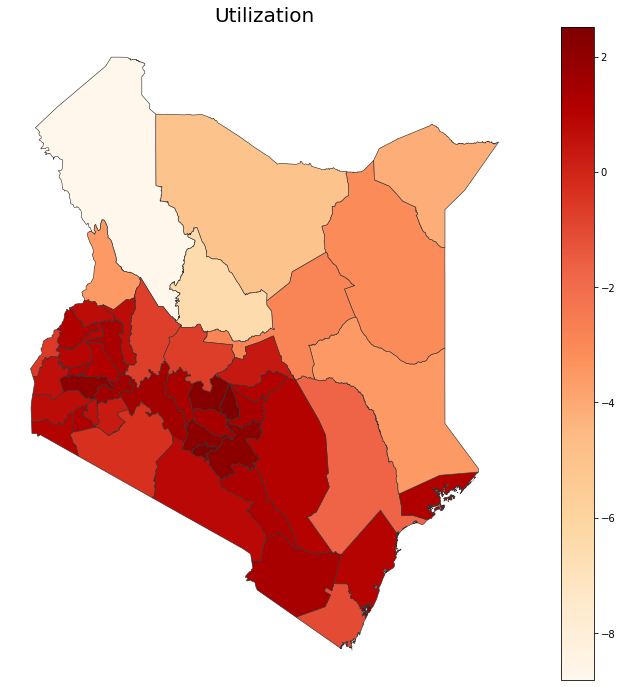

In [26]:
fig, ax = plt.subplots(1, figsize=(14,12))
fs_df.plot(column=fs_df.utilization.map(lambda p:p*-1), cmap='OrRd', linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax);
ax.axis('off')
ax.set_title("Utilization",fontsize=20);


# Stability

In [27]:
stability_df.head()

,Rural_Population,Urban_Population,Total Population,Population_Density/sqKm,Food_Source_Purchases,Food_Source_Stock,Food_Source_Own_production
Code,,,,,,,
1,0.0,1208333.0,1208333.0,5346.606195,88.9,7.5,0.4
2,740389.0,126431.0,866820.0,105.158316,70.9,4.8,20.7
3,1059899.0,393888.0,1453787.0,116.302960,70.0,7.5,15.5
4,240221.0,75722.0,315943.0,8.353419,81.1,4.7,9.0
5,105474.0,38446.0,143920.0,23.321990,76.3,6.0,13.2


### PCA Analysis

In [28]:
x = stability_df.loc[:, stability].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA Analysis
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
fs_df["stability"]=principalComponents

In [29]:
fs_df.head()

,COUNTY,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),...,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID,geometry,availability,accessibility,utilization,stability
Code,,,,,,,,,,,,,,,,,,,,,
1,Mombasa,1.0,11.9,2.5,2.6,2.2,1.0,7.0,8.0,309.0,...,44.2,27.2,1184.868526,0.651168,28,MULTIPOLYGON (...,0.647122,-1.003830,-2.196242,4.890243
2,Kwale,2.0,13.9,2.5,0.4,5.9,2.0,18.0,20.0,62103.0,...,82.7,44.7,876.933624,0.536560,19,MULTIPOLYGON (...,-0.482050,0.690094,1.050718,-0.089574
3,Kilifi,3.0,10.8,1.4,1.3,7.0,1.0,12.0,13.0,54675.0,...,65.9,1.6,822.434090,0.480857,14,MULTIPOLYGON (...,-0.957589,0.559464,-0.977813,0.415435
4,Tana River,4.0,11.4,6.0,1.6,17.9,5.0,15.0,20.0,3536.0,...,74.9,38.3,563.185214,0.291208,40,POLYGON ((38.7...,-2.819730,1.782179,1.699942,0.649419
5,Lamu,5.0,10.5,4.3,1.5,3.2,0.0,8.0,8.0,29025.0,...,67.8,34.4,812.305999,0.468851,21,MULTIPOLYGON (...,-1.074569,-0.626839,-1.176142,0.232931


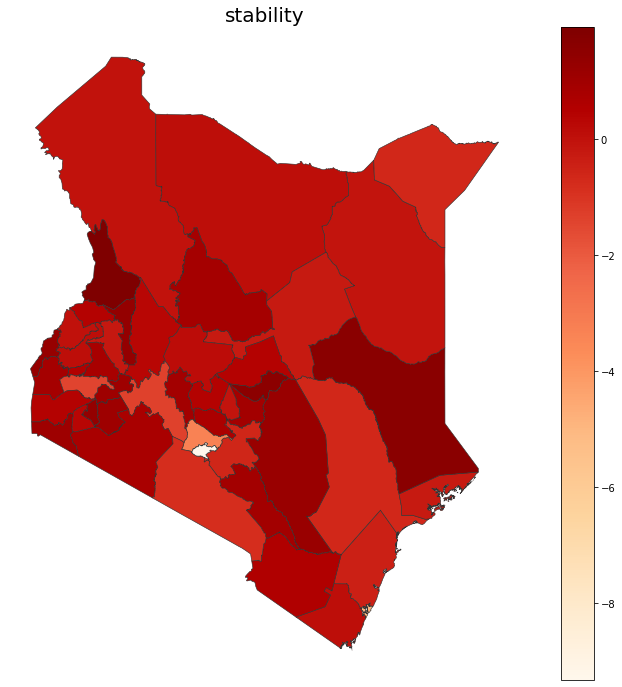

In [30]:
fig, ax = plt.subplots(1, figsize=(14,12))

fs_df.plot(column=fs_df.stability.map(lambda p:p*-1), cmap='OrRd', linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax);
ax.axis('off')
ax.set_title("stability",fontsize=20);

# CLustering

In [31]:
from sklearn.mixture import GaussianMixture

In [32]:
X=fs_df[["availability","accessibility","stability","utilization"]]
EM = GaussianMixture(n_components=11)

EM.fit(X)

cluster = EM.predict(X)
# cluster
fs_df['cluster']=cluster

In [33]:
fs_df.head()

,COUNTY,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),...,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID,geometry,availability,accessibility,utilization,stability,cluster
Code,,,,,,,,,,,,,,,,,,,,,
1,Mombasa,1.0,11.9,2.5,2.6,2.2,1.0,7.0,8.0,309.0,...,27.2,1184.868526,0.651168,28,MULTIPOLYGON (...,0.647122,-1.003830,-2.196242,4.890243,4
2,Kwale,2.0,13.9,2.5,0.4,5.9,2.0,18.0,20.0,62103.0,...,44.7,876.933624,0.536560,19,MULTIPOLYGON (...,-0.482050,0.690094,1.050718,-0.089574,5
3,Kilifi,3.0,10.8,1.4,1.3,7.0,1.0,12.0,13.0,54675.0,...,1.6,822.434090,0.480857,14,MULTIPOLYGON (...,-0.957589,0.559464,-0.977813,0.415435,10
4,Tana River,4.0,11.4,6.0,1.6,17.9,5.0,15.0,20.0,3536.0,...,38.3,563.185214,0.291208,40,POLYGON ((38.7...,-2.819730,1.782179,1.699942,0.649419,8
5,Lamu,5.0,10.5,4.3,1.5,3.2,0.0,8.0,8.0,29025.0,...,34.4,812.305999,0.468851,21,MULTIPOLYGON (...,-1.074569,-0.626839,-1.176142,0.232931,10


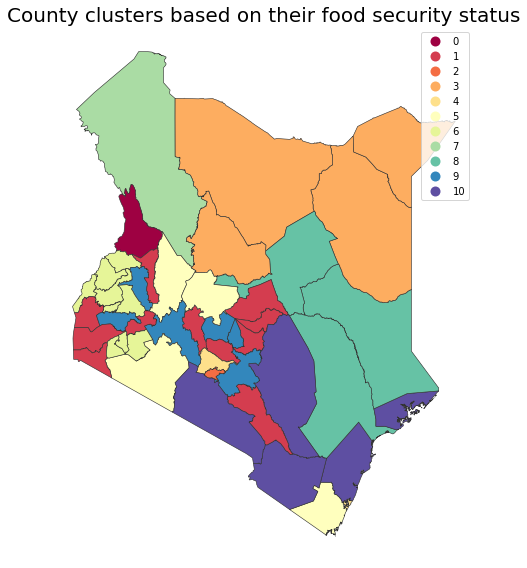

In [34]:
# fs_df.plot(column='cluster', cmap='OrRd', edgecolor='k');


fig, ax = plt.subplots(1, figsize=(14,8))
fs_df.plot(column='cluster', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax)
ax.axis('off')
ax.set_title('County clusters based on their food security status',fontsize=20)
plt.tight_layout()


# NEXT WEEK TASKS
* [ ] Read on the various clustering algorithms 
* [ ] Choose the clustering algorithms to use and identify the number of clusters.
* [ ] Understand the results of the analysis
